In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd 
from IPython.display import display, HTML
import html # Import the standard 'html' library

FOLDER_PATH = "../../../../../../../data/rrochas/raw_data/Manhattan"
SAVE_PATH = "../../../../data/rrochas/prediction_validation/Manhattan"

# --- Load gdf: 
remote_df = pd.read_excel(f'{FOLDER_PATH}/Remote-Booth-Station.xls', index_col=0) 
gdf = gpd.read_file(f'{SAVE_PATH}/subway_stations.shp',crs = 'EPSG:4326',index_col=0)
gdf= gdf[['GTFS Stop', 'Station ID', 'Complex ID','Borough','Structure','GTFS Latit','GTFS Longi','geometry']]

# --- Load MTA data 
MTA_raw = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership__2020-2024_20250813.csv') # 49 M lignes

# Two Ways of filtering Manhatta Stations (totally different results):

In [114]:
# --- Restrict to Manhattan: 
df_manhattan_raw = MTA_raw[MTA_raw['station_complex_id'].isin(gdf['Complex ID'])]
# df_manhattan_raw = MTA_raw[MTA_raw['borough'] == 'Manhattan'] # Alternative way to filter manhattan 
print(f'df_manhattan: (size: {len(df_manhattan_raw)})')
display(df_manhattan_raw.head())

df_manhattan: (size: 666844)


,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
4653056,09/08/2022 05:00:00 AM,subway,8,"5 Av/59 St (N,R,W)",Manhattan,metrocard,Metrocard - Unlimited 30-Day,3.0,0.0,40.764812,-73.973350,POINT (-73.97335 40.764812)
4653057,09/08/2022 03:00:00 AM,subway,607,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",Manhattan,metrocard,Metrocard - Full Fare,23.0,0.0,40.749718,-73.987820,POINT (-73.98782 40.749718)
4653059,09/08/2022 09:00:00 PM,subway,297,215 St (1),Manhattan,metrocard,Metrocard - Unlimited 30-Day,4.0,0.0,40.869446,-73.915276,POINT (-73.915276 40.869446)
4653060,09/08/2022 10:00:00 AM,subway,409,Spring St (6),Manhattan,metrocard,Metrocard - Students,1.0,0.0,40.722300,-73.997140,POINT (-73.99714 40.7223)
4653061,09/08/2022 06:00:00 AM,subway,618,"14 St (A,C,E)/8 Av (L)",Manhattan,metrocard,Metrocard - Full Fare,49.0,7.0,40.740894,-74.001690,POINT (-74.00169 40.740894)


# Visualisation of flow per stations: 

In [159]:
gdf_from_flows = gpd.GeoDataFrame(df_manhattan_raw.groupby('station_complex_id').agg({'latitude': 'first',
                                                                                      'longitude': 'first',
                                                                                      'ridership': 'sum',
                                                                                      })
                                                                                      )
gdf_from_flows = gdf_from_flows.set_geometry(gpd.points_from_xy(gdf_from_flows.longitude, gdf_from_flows.latitude))
gdf_from_flows.crs = 'EPSG:4326'

gdf_from_flows['ridership_100k'] = gdf_from_flows['ridership'] / 100000

m = gdf_from_flows.explore('ridership_100k',
        tiles = 'CartoDB positron', 
        marker_type = 'circle',
        style_kwds={'style_function': lambda x: {'radius': np.sqrt(x['properties']['ridership'])/5} },
        legend_kwds={'caption': 'Ridership in hundred of k'}
        )

map_html_string = m._repr_html_()
escaped_map_html = html.escape(map_html_string, quote=True)
iframe_html = f'<iframe srcdoc="{escaped_map_html}" width="{800}" height="{400}" style="border:none;"></iframe>'
display(HTML(iframe_html))

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Analysis number of covered dates : 

In [160]:
# Convert datetime :
df_manhattan = df_manhattan_raw.copy()
df_manhattan['transit_timestamp'] = pd.to_datetime(df_manhattan['transit_timestamp'], 
                                                   format='%m/%d/%Y %I:%M:%S %p',
                                                   errors='coerce')

print('df_manhattan after transformed datetime: ')
display(df_manhattan.head())

df_manhattan after transformed datetime: 


,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
4653056,2022-09-08 05:00:00,subway,8,"5 Av/59 St (N,R,W)",Manhattan,metrocard,Metrocard - Unlimited 30-Day,3.0,0.0,40.764812,-73.973350,POINT (-73.97335 40.764812)
4653057,2022-09-08 03:00:00,subway,607,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",Manhattan,metrocard,Metrocard - Full Fare,23.0,0.0,40.749718,-73.987820,POINT (-73.98782 40.749718)
4653059,2022-09-08 21:00:00,subway,297,215 St (1),Manhattan,metrocard,Metrocard - Unlimited 30-Day,4.0,0.0,40.869446,-73.915276,POINT (-73.915276 40.869446)
4653060,2022-09-08 10:00:00,subway,409,Spring St (6),Manhattan,metrocard,Metrocard - Students,1.0,0.0,40.722300,-73.997140,POINT (-73.99714 40.7223)
4653061,2022-09-08 06:00:00,subway,618,"14 St (A,C,E)/8 Av (L)",Manhattan,metrocard,Metrocard - Full Fare,49.0,7.0,40.740894,-74.001690,POINT (-74.00169 40.740894)


In [161]:
#  Let's count that kind of 'row' with the same 'transit_timestamp':

# Example row:
# transit_timestamp                  2022-12-14 13:00:00
# transit_mode                                    subway
# station_complex_id                                 610
# [...]
# ridership                                          4.0
# Georeference              POINT (-73.976845 40.751778)
# Name: 1, dtype: object
collected_per_hours =  df_manhattan.transit_timestamp.value_counts()
display(collected_per_hours.head())

transit_timestamp
2023-06-03 12:00:00    903
2023-06-03 16:00:00    897
2023-06-03 13:00:00    892
2023-06-03 15:00:00    890
2023-06-03 17:00:00    890
Name: count, dtype: int64

In [162]:
# --- Reindex to have continuous hourly index
start = collected_per_hours.index.min()
end = collected_per_hours.index.max()
collected_per_hours = collected_per_hours.reindex(pd.date_range(start=start, end=end, freq='H')).fillna(0)
display(collected_per_hours.head())

/tmp/ipykernel_20307/121751451.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  collected_per_hours = collected_per_hours.reindex(pd.date_range(start=start, end=end, freq='H')).fillna(0)


2020-10-15 09:00:00    1.0
2020-10-15 10:00:00    0.0
2020-10-15 11:00:00    0.0
2020-10-15 12:00:00    0.0
2020-10-15 13:00:00    0.0
Freq: h, Name: count, dtype: float64

In [163]:
# --- Reset index and extract date features
df = collected_per_hours.reset_index()
df['day'] = df['index'].dt.day_name()
df['week_year'] = df['index'].dt.strftime('%Y-%U')
display(df.head())

,index,count,day,week_year
0,2020-10-15 09:00:00,1.0,Thursday,2020-41
1,2020-10-15 10:00:00,0.0,Thursday,2020-41
2,2020-10-15 11:00:00,0.0,Thursday,2020-41
3,2020-10-15 12:00:00,0.0,Thursday,2020-41
4,2020-10-15 13:00:00,0.0,Thursday,2020-41


In [164]:
# 1. Group df by (week_year, dayofweek)
#  and 
# 2. aggregated with 'sum' 
#  to get total counts of hourly aggregated records per day (idenfied by a tuple [week_year, dayofweek])
df_grouped = df.groupby(['week_year','day']).agg({'count':'sum'}).reset_index()
display(df_grouped.head())
df_pivot = df_grouped.pivot(index='week_year', columns='day', values='count')
df_pivot = df_pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
display(df_pivot.head())

,week_year,day,count
0,2020-41,Friday,0.0
1,2020-41,Saturday,0.0
2,2020-41,Thursday,2.0
3,2020-42,Friday,0.0
4,2020-42,Monday,5939.0


day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
week_year,,,,,,,
2020-41,NaN,NaN,NaN,2.0,0.0,0.0,NaN
2020-42,5939.0,0.0,0.0,10.0,0.0,0.0,0.0
2020-43,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-44,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-45,0.0,0.0,0.0,0.0,0.0,0.0,0.0


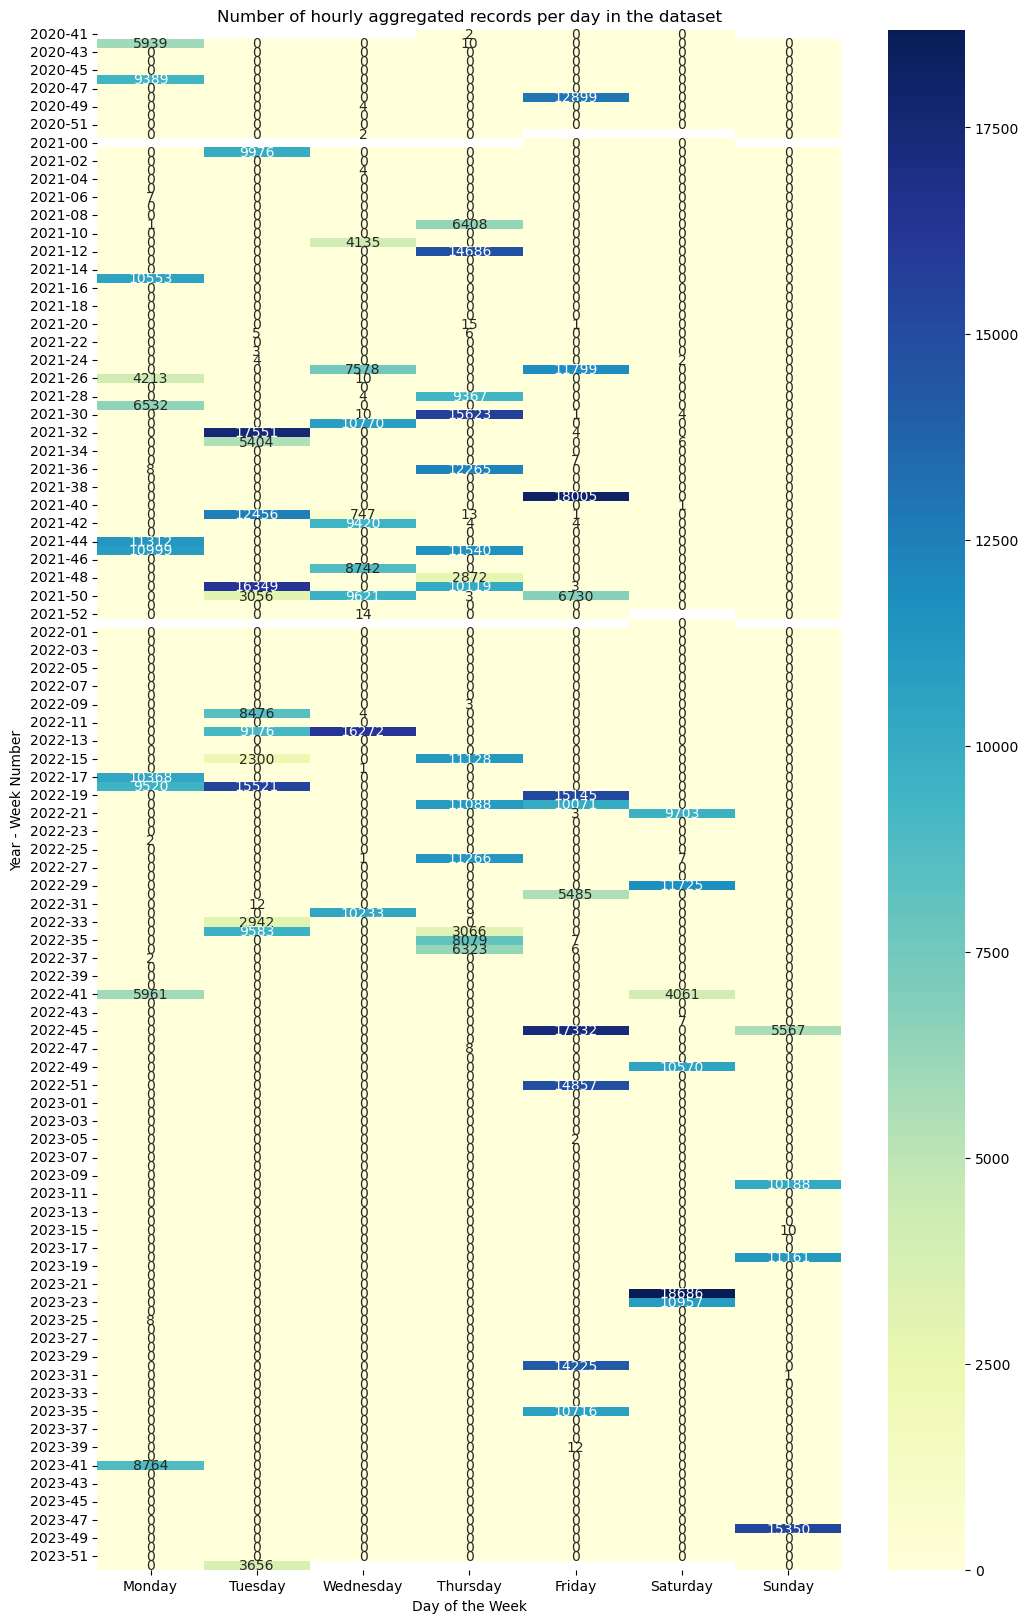

In [165]:
# Visualize samples per days with seaborn:
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Plot heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(df_pivot, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title("Number of hourly aggregated records per day in the dataset")
plt.xlabel("Day of the Week")
plt.ylabel("Year - Week Number")
plt.show()


## Recorded Flow: 

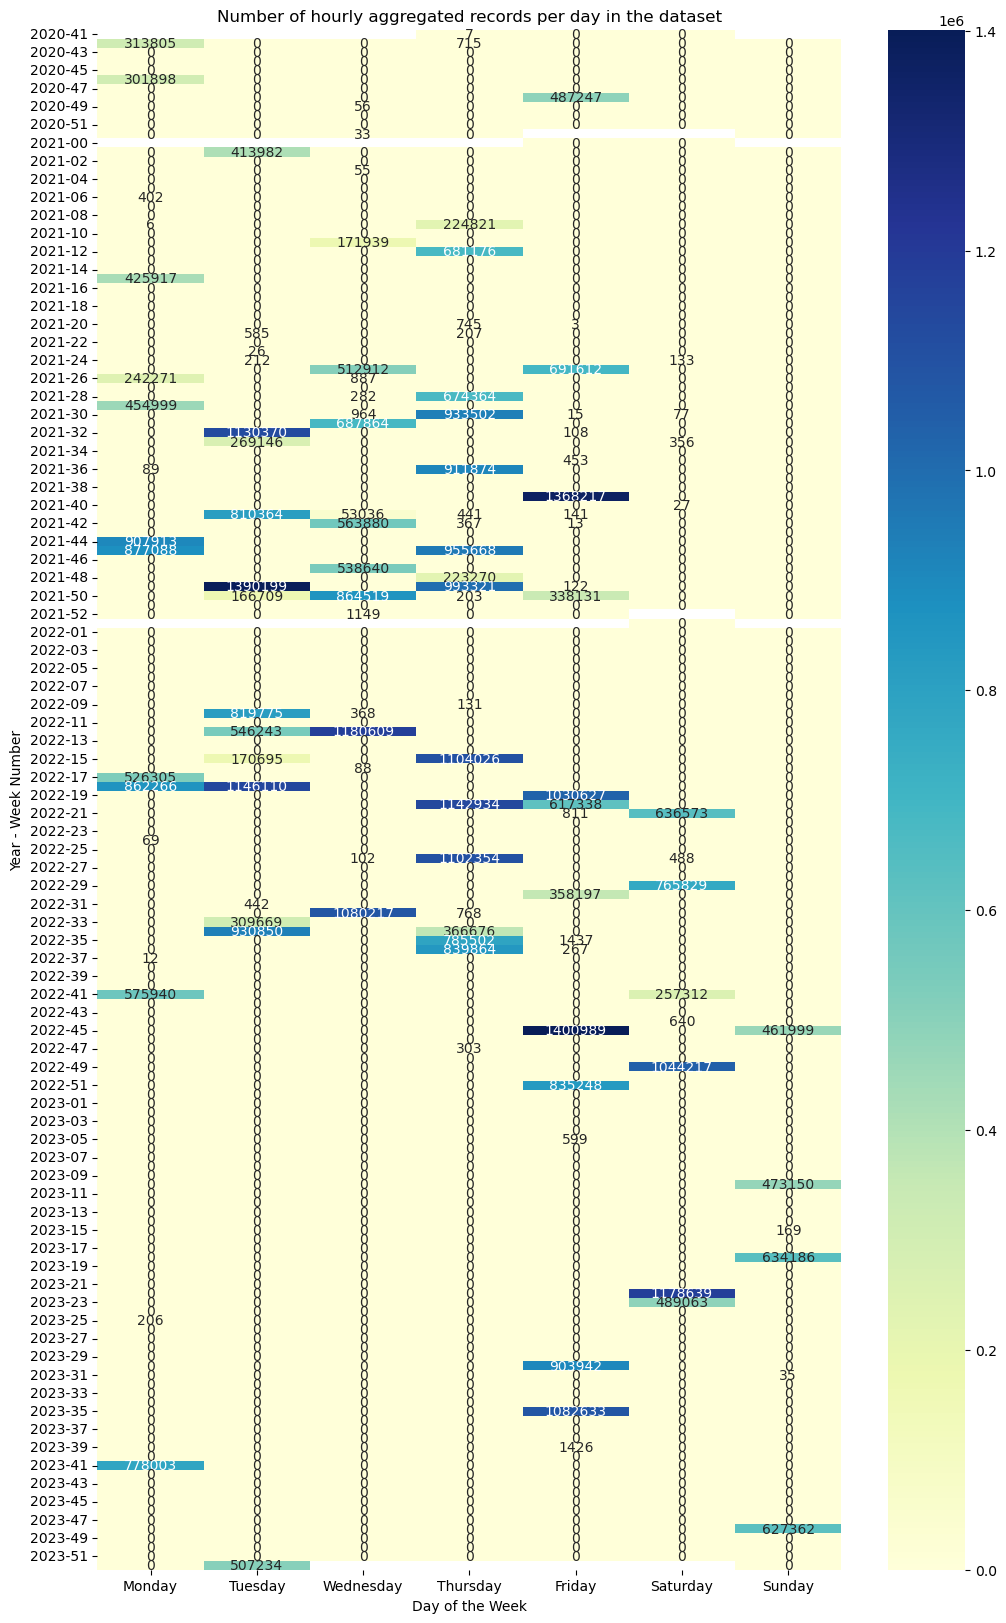

In [166]:


df_ridership = df_manhattan.set_index('transit_timestamp')[['ridership']]
df_ridership = df_ridership.resample('d').sum()
start = df_ridership.index.min()
end = df_ridership.index.max()
ridership_per_hours = df_ridership.reindex(pd.date_range(start=start, end=end, freq='d')).fillna(0)

df = ridership_per_hours.copy().reset_index()
df['day'] = df['index'].dt.day_name()
df['week_year'] = df['index'].dt.strftime('%Y-%U')
df_pivot = df.pivot(index='week_year', columns='day', values='ridership')
df_pivot = df_pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]


plt.figure(figsize=(12, 20))
sns.heatmap(df_pivot, cmap='YlGnBu', annot=True,
            fmt=".0f"
           )  # Set color bar format to scientific notation


plt.title("Number of hourly aggregated records per day in the dataset")
plt.xlabel("Day of the Week")
plt.ylabel("Year - Week Number")
plt.show()


# Number of missing dates within Manhattan : 

Text(0, 0.5, 'Number of Complex IDs with \nthat number of unique dates')

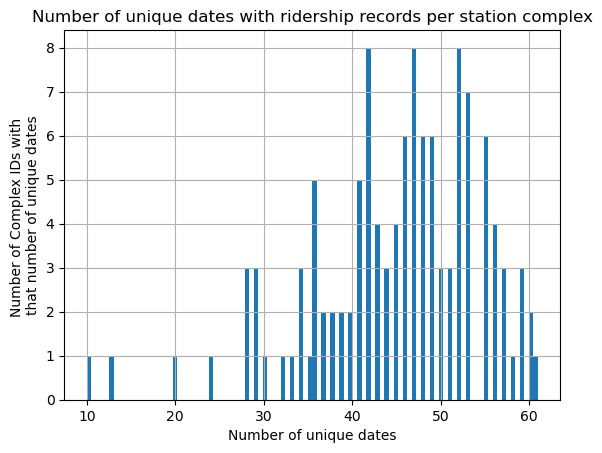

In [169]:
n_dates_per_stations =  df_manhattan.groupby('station_complex_id')['transit_timestamp'].apply(lambda s: len(s.dt.date.unique()))
n_dates_per_stations.hist(bins=100)
plt.title("Number of unique dates with ridership records per station complex")
plt.xlabel("Number of unique dates")
plt.ylabel("Number of Complex IDs with \nthat number of unique dates")
